In [1]:
# SHAP values
import shap
shap.initjs()

In [2]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [3]:
data = pd.read_csv('../MobilityDistance/tax_residential_mobility_distance_500_no_impute.csv')
data = data.sample(5000)

In [4]:
cens_cols = [i for i in data.columns[-45:]]
mob_cols = [i for i in data.columns if '__' in i]

In [5]:
x = data.drop(['property_id', 'PROPTYPE', 'LANDAREA','2019ASSESSMENT', 'REALADD', 'RESCOMM','Longitude', 'Latitude', 'census_block_group', 'CITY','GENPROPTYPE'],
              axis=1).dropna()
y = np.log(data.dropna()['2019ASSESSMENT'])

In [6]:
data['2019ASSESSMENT'].describe()

count    5.000000e+03
mean     7.125397e+05
std      3.138098e+06
min      5.002353e+04
25%      2.820106e+05
50%      4.714094e+05
75%      7.558638e+05
max      1.534738e+08
Name: 2019ASSESSMENT, dtype: float64

<AxesSubplot:xlabel='2019ASSESSMENT', ylabel='Density'>

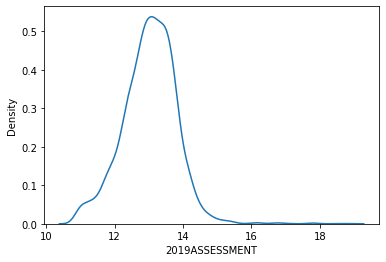

In [7]:
sns.kdeplot(y)

In [ ]:
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=42,n_estimators=1000,n_jobs=-1).fit(X_train,y_train)
predictionsRF = rfr.predict(X_test)

mseRF = mean_squared_error(y_test, predictionsRF)
print('MSE', mseRF)
print('R squared', rfr.score(X_test, y_test))

pd.set_option("display.max_rows",150)
importance = list(rfr.feature_importances_)
features = list(X_train.columns)
p = pd.DataFrame({'feature':features,'importance':importance})
p.sort_values(by='importance',ascending=False)[:10]

In [8]:
# transformed y
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=42,n_estimators=1000,n_jobs=-1).fit(X_train,y_train)
predictionsRF = rfr.predict(X_test)

mseRF = mean_squared_error(y_test, predictionsRF)
print('MSE', mseRF)
print('R squared', rfr.score(X_test, y_test))

pd.set_option("display.max_rows",150)
importance = list(rfr.feature_importances_)
features = list(X_train.columns)
p = pd.DataFrame({'feature':features,'importance':importance})
p.sort_values(by='importance',ascending=False)[:10]

MSE 0.30371113992541904
R squared 0.4817607371097745


feature  importance
114           5__Median_Household_Income    0.144544
26            1__Median_Household_Income    0.082349
115  5__civilian_laborforce_unemployment    0.059844
136           6__Median_Household_Income    0.020700
125     5__OneOrMore_PersonPerRoom_Owner    0.012896
147     6__OneOrMore_PersonPerRoom_Owner    0.011965
92            4__Median_Household_Income    0.011063
4             0__Median_Household_Income    0.009384
70            3__Median_Household_Income    0.009047
132                   6__dwell_estimated    0.008529

In [9]:
X100 = shap.utils.sample(X_train, 100)
explainer = shap.TreeExplainer(rfr, X_train)

In [10]:
shap_values = explainer.shap_values(X_train,check_additivity=False)
shap_values

100%|===================| 4498/4500 [69:04<00:01]        

array([[ 3.25021031e-03,  5.74894099e-03, -1.39313876e-03, ...,
         1.23083492e-05, -3.88472816e-03, -1.54315678e-03],
       [-1.63454546e-03, -4.01536805e-03,  2.90845182e-03, ...,
         1.20703361e-03,  6.86378571e-03,  4.60931967e-03],
       [-2.42702680e-03, -1.46198713e-03, -2.87979073e-03, ...,
         1.11004957e-03, -4.95312495e-03,  1.87642021e-03],
       ...,
       [ 3.32873264e-03, -2.51892105e-04, -2.55385055e-04, ...,
         3.94718837e-04, -4.51436377e-03, -1.16901870e-03],
       [-4.94294071e-03, -1.98622882e-03, -9.00387098e-03, ...,
        -1.26955609e-03, -1.64860546e-03, -1.18642312e-03],
       [-2.00132796e-04,  1.12205829e-04,  2.11805621e-03, ...,
         8.88253212e-05,  1.83985339e-02,  5.61623248e-03]])

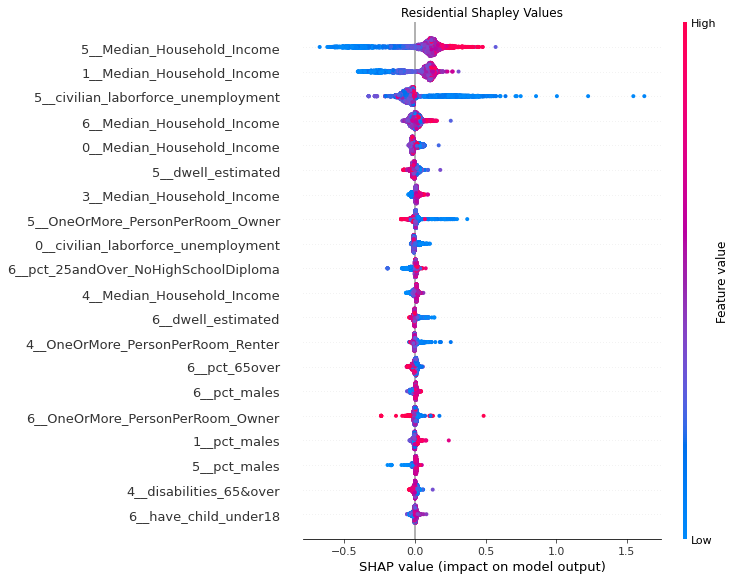

In [11]:
import matplotlib.pyplot as plt

plt.title('Residential Shapley Values')

shap.summary_plot(shap_values, X_train, max_display=20)

In [1]:
import folium

map_people= folium.Map(
    location=[38.9072, -77.0369],
    tiles='cartodbpositron',
    zoom_start=10,
    )

In [4]:
plotting_data = data.copy()
plotting_data['average_people'] = plotting_data[[i for i in plotting_data.columns if 'people_in_area' in i]].mean(axis=1)
plotting_data['price_quartile'] = pd.qcut(plotting_data['2019ASSESSMENT'], 4, labels=False)
plotting_data['average_residents'] = plotting_data[[i for i in plotting_data.columns if 'residents' in i]].mean(axis=1)


colordict = {0: 'yellow', 1: 'orange', 2: 'red', 3: 'darkred'}
for lat, lon, price, residents, people in zip(plotting_data['Latitude'], plotting_data['Longitude'], plotting_data['price_quartile'], plotting_data['average_residents'], plotting_data['average_people']):    
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        color='b',
        key_on = price,
        threshold_scale=[0,1,2,3],
        fill_color=colordict[price],
        fill=True,
        fill_opacity=0.7
        ).add_to(map_people)

In [5]:
map_people